In [1]:
import sys
sys.path.append('../python_packages_static/')
import os, glob, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import flopy.utils as fu
import platform

# 1. MODPATH file setup

### 1.0 Set paths and pointers to MODFLOW6 executable and namefile

In [2]:
home = os.getcwd()
upone = os.path.dirname(home)
model_ws = os.path.join(upone, 'neversink_mf6')
modflow_executable = os.path.join(upone, 'neversink_mf6', 'mf6') # modpath executable in neversink_mf6 directory
simname = 'mfsim.nam'

### 1.1 Make MODFLOW Object
Make a flopy modlfow object using the `.nam` file

In [3]:
sim = flopy.mf6.MFSimulation.load(simname, 'mf6', sim_ws=model_ws, exe_name=modflow_executable)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package oc...
    loading package wel...
    loading package obs...
    loading package chd...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 176 based on size of stress_period_data
    loading package sfr...
  loading ims package neversink...


### 1.2 Run the modflow model
can skip if this if model has already been run in `neversink_mf6`

In [4]:
#sim.run_simulation()

### 1.3 Load model simulation

In [5]:
m = sim.get_model()

In [6]:
nlay = m.dis.nlay.data
nrow = m.dis.nrow.data
ncol = m.dis.ncol.data
print(nlay, nrow, ncol)

4 680 619


###  1.4 Get priority wells and determine MODPATH nodes

In [7]:
wells_df = pd.read_csv('../processed_data/2009-2016_ave_pumping.csv')
wells_df = wells_df.loc[wells_df.WellType == 'Priority']
priority_wells = wells_df.ID_Well.tolist()
priority_wells

['SV_193', 'SV_227', 'U__55', 'U_917', 'U___7', 'U___8', 'SV_407', 'SV_487']

In [8]:
#  make well id dict to help keep id's 

particle_ids = []
idx = 0

for idx in range(0, len(priority_wells)):
    particle_ids.append(idx)
    idx += 1
    
modpath_id_dict = dict(zip(particle_ids, priority_wells))
modpath_id_dict

{0: 'SV_193',
 1: 'SV_227',
 2: 'U__55',
 3: 'U_917',
 4: 'U___7',
 5: 'U___8',
 6: 'SV_407',
 7: 'SV_487'}

**1.4.1 All Neversink model wells from `stress_period_data`**

In [9]:
#  if we want MODPATH particles in all wells -- we probably don't

particle_locations_allwells = m.wel.stress_period_data.get_data()[0]['cellid']
particle_locations_allwells

array([(2, 324, 218), (0, 346, 208), (3, 234, 183), (0, 248, 181),
       (3, 328, 317), (2, 322, 291), (3, 376, 482), (0, 299, 255),
       (3, 299, 255), (3, 285, 352), (0, 556, 459), (3, 557, 459),
       (0, 225, 185), (3, 226, 185), (3, 223, 202), (3, 234, 186),
       (3, 237, 198), (3, 236, 185), (3, 237, 198), (1, 579, 458),
       (2, 301, 174), (3, 260, 180), (2, 249, 181), (1, 247, 538),
       (1, 228, 536), (1, 249, 536), (1, 248, 536), (3, 143, 215),
       (3, 143, 215), (3, 143, 216), (3, 143, 216), (3, 245, 182),
       (3, 165, 157), (3, 218, 178)], dtype=object)

**1.4.2 Priority wells from `well_000.dat` with zero-based adjustment**

In [10]:
well_dat_df = pd.read_csv('../neversink_mf6/wel_000.dat', delim_whitespace=True)
well_dat_df = well_dat_df.loc[well_dat_df.boundname.isin(priority_wells)]

well_dat_df['k_zb'] = well_dat_df['#k'] - 1
well_dat_df['i_zb'] = well_dat_df['i'] - 1
well_dat_df['j_zb'] = well_dat_df['j'] - 1
particle_locations = [(x, y, z) for x, y, z in zip(well_dat_df['k_zb'], 
                                                   well_dat_df['i_zb'], 
                                                   well_dat_df['j_zb'])]
particle_locations

[(2, 324, 218),
 (0, 346, 208),
 (2, 322, 291),
 (0, 556, 459),
 (1, 247, 538),
 (1, 228, 536),
 (1, 249, 536),
 (1, 248, 536)]

**1.4.3 convert well locations to nodes for modpath**

In [11]:
def get_nodes(locs):
    nodes = []
    for k, i, j in locs:
        nodes.append(k * nrow * ncol + i * ncol + j)
    return nodes

In [12]:
dest_nodes = get_nodes(particle_locations)

In [13]:
dest_nodes # these are important for particle tracking

[1042614, 214382, 1041449, 344623, 574351, 562588, 575587, 574968]

### 1.4.4 Update nodes in particle tracking script

In [14]:
get_endpoints_script = '../scripts/get_endpoints.py'

update_line = f'    dest_nodes = {dest_nodes}\n'

infile = open(get_endpoints_script, 'r').readlines()
with open(get_endpoints_script, 'w') as ofp:
    [ofp.write(update_line) if line.startswith('    dest_nodes =') else ofp.write(line) for line in infile]

### 1.5 set starting locations for forward particles
we can use particle locations to set up forward tracking subset of grid.

In [15]:
well_i,well_j = well_dat_df['i_zb'],well_dat_df['j_zb']
idm = m.dis.idomain.data[-1]

**Add setup particle zones for NE, W and S priority well "clusters" -- for running on the array**

partlox_NE particles in 2.67 % of model cells


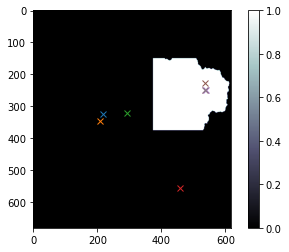

In [16]:
partlox_NE = idm.copy().astype(float)

partlox_NE[0:150,:]=0
partlox_NE[375:,:]=0
partlox_NE[:,0:375]=0

print('partlox_NE particles in {} % of model cells'.format(round(sum(sum(partlox_NE))/(nlay*nrow*ncol) * 100, 2)))

[plt.plot(j,i,'x') for i,j in zip(well_i,well_j)]
partlox_NE[partlox_NE>1]=np.nan
plt.imshow(partlox_NE, cmap='bone')
plt.colorbar()
plt.show()

partlox_W particles in 2.84 % of model cells


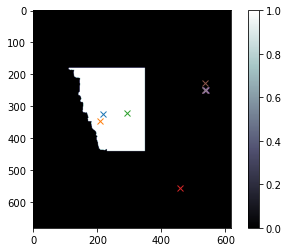

In [17]:
partlox_W = idm.copy().astype(float)

partlox_W[0:-500,:]=0
partlox_W[440:,:]=0
partlox_W[:,350:]=0

print('partlox_W particles in {} % of model cells'.format(round(sum(sum(partlox_W))/(nlay*nrow*ncol) * 100, 2)))

[plt.plot(j,i,'x') for i,j in zip(well_i,well_j)]
partlox_W[partlox_W>1]=np.nan
plt.imshow(partlox_W, cmap='bone')
plt.colorbar()
plt.show()

partlox_S particles in 1.74 % of model cells


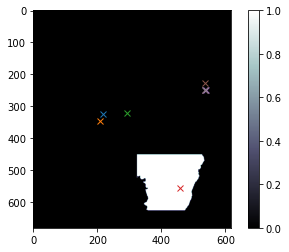

In [18]:
partlox_S = idm.copy().astype(float)

partlox_S[0:450,:]=0
partlox_S[625:,:]=0
partlox_S[:,0:325]=0

print('partlox_S particles in {} % of model cells'.format(round(sum(sum(partlox_S))/(nlay*nrow*ncol) * 100, 2)))

[plt.plot(j,i,'x') for i,j in zip(well_i,well_j)]
partlox_S[partlox_S>1]=np.nan
plt.imshow(partlox_S, cmap='bone')
plt.colorbar()
plt.show()

In [19]:
#  function to get modpath starting particle nodes from 1/0 arrays (1 for particle, 0 for no paricle)
def get_starting_nodes(partlox):
    cells = np.where(partlox>0)
    pi,pj = cells
    irch = m.rch.irch.data
    pk = irch[pi,pj]
    forward_cells = list(zip(pk,pi,pj))
    forward_nodes = get_nodes(forward_cells)
    return forward_nodes

In [20]:
forward_nodes_partlox_NE = get_starting_nodes(partlox_NE)
forward_nodes_partlox_W = get_starting_nodes(partlox_W)
forward_nodes_partlox_S = get_starting_nodes(partlox_S)

In [21]:
all_forward_nodes = [forward_nodes_partlox_NE,forward_nodes_partlox_W,forward_nodes_partlox_S]

### 1.6 Create NE, W and S zone modpath files

In [22]:
#  flag if setting up files for run on linux
setup_for_linux = True

In [23]:
#  create NE, W and S zone modpath files
mpnamf_zones = ['neversink_mp_forward_weak_NE', 'neversink_mp_forward_weak_W', 'neversink_mp_forward_weak_S']

if setup_for_linux is not True:
    if sys.platform == 'win32':
        modpath_executable = 'mp7.exe' # path to windows MODPATH7 executable, assume same directory as modpath files
    else:
        modpath_executable='mp7'       # path to mac/linux MODPATH7 executable, assume same directory as modpath files
        
if setup_for_linux is True:
    modpath_executable='mp7'
    
for zone, forward_nodes in zip(mpnamf_zones, all_forward_nodes):
    mp = flopy.modpath.Modpath7.create_mp7(
        modelname=zone, 
        trackdir='forward', 
        flowmodel=m, 
        model_ws=model_ws, 
        rowcelldivisions=1, 
        columncelldivisions=1, 
        layercelldivisions=1,
        nodes=forward_nodes,
        exe_name=modpath_executable
    )
    
    # write modpath datasets
    mp.write_input()
    print('Wrote {} MODPATH input files'.format(zone))

Wrote neversink_mp_forward_weak_NE MODPATH input files
Wrote neversink_mp_forward_weak_W MODPATH input files
Wrote neversink_mp_forward_weak_S MODPATH input files


In [24]:
# fix mpbas to set iface for SFR (we don't care about EVT) -- same as above
for cf in glob.glob('../neversink_mf6/*.mpbas'):
    cbas = [i.strip() for i in open(cf, 'r').readlines()]
    with open(cf, 'w') as ofp:
        [ofp.write('{}\n'.format(i.replace('EVT','SFR'))) for i in cbas]

In [25]:
# modify to make models weak sink and set Drape = 1 option for placing particles
for zone in mpnamf_zones: 
    with open('../neversink_mf6/{}.mpsim'.format(zone), 'r') as ofp:
        inmpsim = ofp.readlines()
    
    inmpsim[3] = '4 1 2 1 0 0\n'
    tmp = inmpsim[22].strip().split()
    inmpsim[22] = ' '.join(tmp[:2]) + ' 1\n'

    with open('../neversink_mf6/{}.mpsim'.format(zone), 'w') as ofp:
        ofp.writelines(inmpsim)
    print('{}.mpsim updated to weak sink setting'.format(zone))

neversink_mp_forward_weak_NE.mpsim updated to weak sink setting
neversink_mp_forward_weak_W.mpsim updated to weak sink setting
neversink_mp_forward_weak_S.mpsim updated to weak sink setting
